In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [3]:
!unzip -qq ./chip_data.zip -d data

In [4]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [5]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

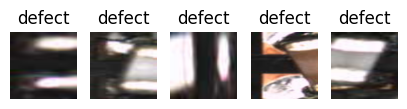

In [6]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [7]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [9]:
# Get the total number of samples in the testing dataset
print(f"Total number of test samples: {len(test_dataset)}")

# Get the shape of the first image in the dataset
first_image1, label = test_dataset[0]
print(f"Shape of the first image: {first_image1.shape}")


Total number of test samples: 121
Shape of the first image: torch.Size([3, 224, 224])


In [10]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
model = models.vgg19(weights = models.VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 77.5MB/s]


In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
# Modify the final fully connected layer to match the dataset classes
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 1)

In [17]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [20]:
# Include the Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epoch [1/10], Train Loss: 0.6126, Validation Loss: 0.5789
Epoch [2/10], Train Loss: 0.6404, Validation Loss: 0.5769
Epoch [3/10], Train Loss: 0.6598, Validation Loss: 0.5784
Epoch [4/10], Train Loss: 0.6183, Validation Loss: 0.5983
Epoch [5/10], Train Loss: 0.6290, Validation Loss: 0.5794
Epoch [6/10], Train Loss: 0.6119, Validation Loss: 0.5719
Epoch [7/10], Train Loss: 0.6529, Validation Loss: 0.5710
Epoch [8/10], Train Loss: 0.6361, Validation Loss: 0.5861
Epoch [9/10], Train Loss: 0.6112, Validation Loss: 0.5889
Epoch [10/10], Train Loss: 0.6310, Validation Loss: 0.5751
Name: Surya Prakash B
Register Number: 212224230281


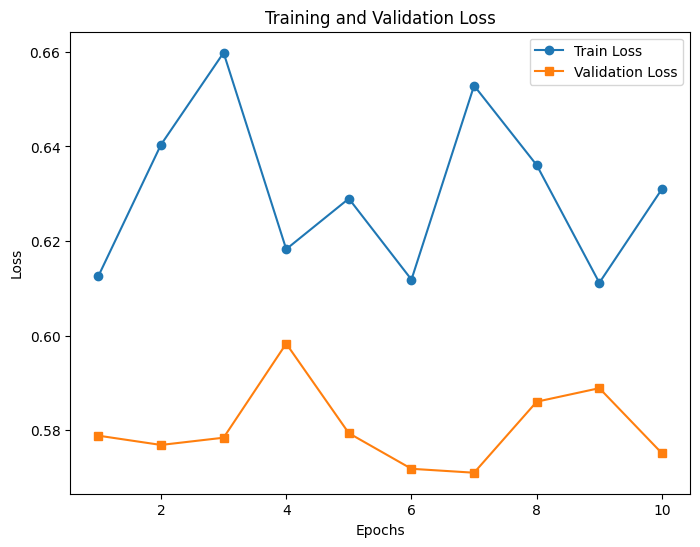

In [34]:
## Step 3: Train the Model
def train_model(model, train_loader, test_loader, num_epochs=100):
  train_losses = []
  val_losses = []
  model.train()
  for epoch in range(num_epochs):
      train_loss = 0.0
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels.unsqueeze(1).float())
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      # Calculate average training loss for the epoch
      avg_train_loss = train_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # Validation loop
      model.eval() # Set model to evaluation mode
      val_loss = 0.0
      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels.unsqueeze(1).float())
              val_loss += loss.item()

      # Calculate average validation loss for the epoch
      avg_val_loss = val_loss / len(test_loader)
      val_losses.append(avg_val_loss)

      model.train() # Set model back to training mode

      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  return train_losses, val_losses # Return the losses

# Define num_epochs for the training run
num_epochs_to_run = 10

# Call the train_model function and get the losses
trained_train_losses, trained_val_losses = train_model(model, train_loader, test_loader, num_epochs=num_epochs_to_run)

# Plot training and validation loss
print("Name: Surya Prakash B")
print("Register Number: 212224230281")
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs_to_run + 1), trained_train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs_to_run + 1), trained_val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [32]:
# Train the model
train_model(model, train_loader, test_loader)

Epoch [1/10], Train Loss: 0.6281, Validation Loss: 0.5750
Epoch [2/10], Train Loss: 0.6159, Validation Loss: 0.5754
Epoch [3/10], Train Loss: 0.6143, Validation Loss: 0.5749
Epoch [4/10], Train Loss: 0.6095, Validation Loss: 0.5782
Epoch [5/10], Train Loss: 0.6113, Validation Loss: 0.5714
Epoch [6/10], Train Loss: 0.6059, Validation Loss: 0.5723
Epoch [7/10], Train Loss: 0.6378, Validation Loss: 0.5740
Epoch [8/10], Train Loss: 0.5943, Validation Loss: 0.5791
Epoch [9/10], Train Loss: 0.6250, Validation Loss: 0.5734
Epoch [10/10], Train Loss: 0.6187, Validation Loss: 0.5760


([0.6280829707781473,
  0.6159387230873108,
  0.6143318116664886,
  0.6095203558603922,
  0.6112873554229736,
  0.6059472411870956,
  0.6377723018328348,
  0.5943187971909841,
  0.6249858438968658,
  0.6186798810958862],
 [0.5750032514333725,
  0.5754359513521194,
  0.5748966708779335,
  0.5782360211014748,
  0.5714076608419418,
  0.5722644627094269,
  0.5740475431084633,
  0.5791303291916847,
  0.5734142065048218,
  0.5759965404868126])

Test Accuracy: 0.7273
Name: Surya Prakash B
Register Number: 212224230281


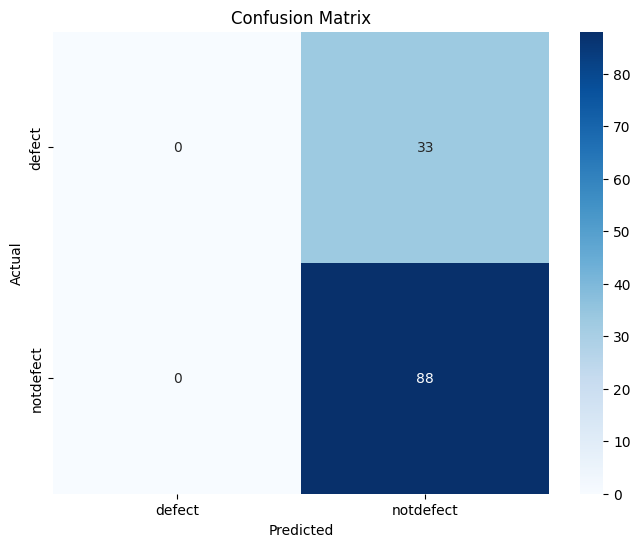

Name: Surya Prakash B
Register Number: 212224230281
Classification Report:
              precision    recall  f1-score   support

      defect       0.00      0.00      0.00        33
   notdefect       0.73      1.00      0.84        88

    accuracy                           0.73       121
   macro avg       0.36      0.50      0.42       121
weighted avg       0.53      0.73      0.61       121



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # For binary classification with BCEWithLogitsLoss, apply sigmoid and threshold
            predicted = (torch.sigmoid(outputs) > 0.5).squeeze().long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name: Surya Prakash B")
    print("Register Number: 212224230281")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name: Surya Prakash B")
    print("Register Number: 212224230281")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Call the test_model function to run evaluation
test_model(model, test_loader)

In [46]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)

        # Apply sigmoid to get probability, threshold at 0.5
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).int().item()


    class_names = dataset.classes
    # Display the image
    image_to_display = transforms.ToPILImage()(image)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted]}')
    plt.axis("off")
    plt.show()

    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted]}')

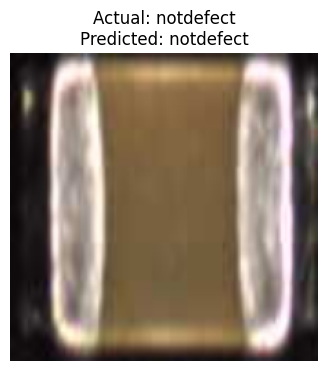

Actual: notdefect, Predicted: notdefect


In [38]:
# Example Prediction
predict_image(model, image_index=55, dataset=test_dataset)


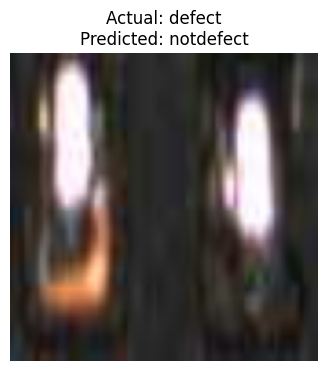

Actual: defect, Predicted: notdefect


In [39]:
#Example Prediction
predict_image(model, image_index=, dataset=test_dataset)